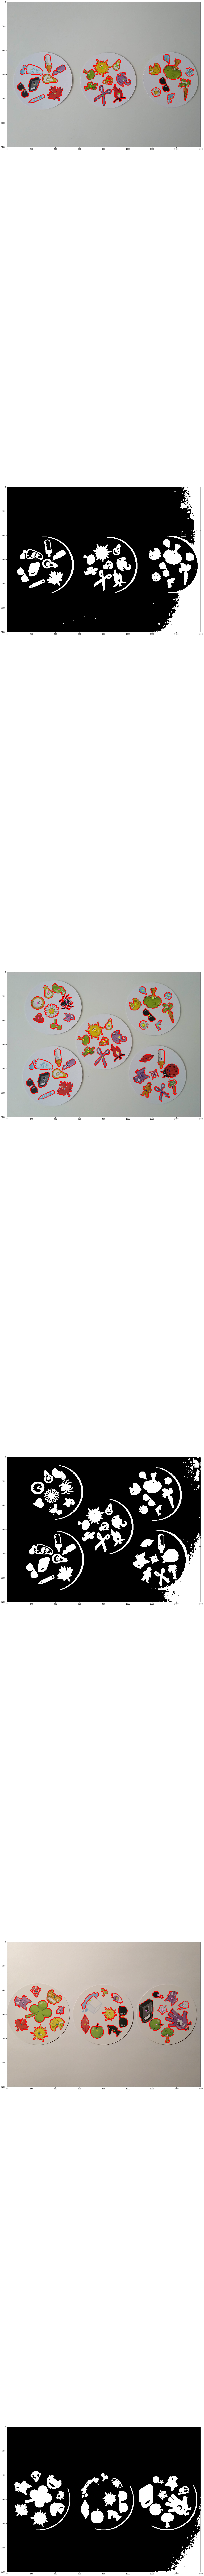

In [99]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from skimage import measure
import cv2
from sklearn.cluster import KMeans
import random

def coords(contour, i):
    xmin = int(np.amin(contour[:,0,1]))
    xmax = int(np.amax(contour[:,0,1]))
    ymin = int(np.amin(contour[:,0,0]))
    ymax = int(np.amax(contour[:,0,0]))
    return xmin-i, xmax+i, ymin-i, ymax+i

def gamma_filter(img):
    MIN = 152
    MAX = 167
    gamma_MIN = 1.0
    gamma_MAX = 1.3
    mean = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    gamma = (MAX - mean)*((gamma_MAX - gamma_MIN)/(MAX-MIN)) + gamma_MIN
    
    invGamma = 1.0/gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)



fig, ax = plt.subplots(6, 1, figsize=(20,300))

photos = ['13', '14', '20']

for i in range(3):
    filename = "./img/dobble"+photos[i]+".jpg"
    img_col = cv2.imread(filename)
    img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)
    img_col = gamma_filter(img_col)

    ret1, img_red_th = cv2.threshold(img_col[:,:,0], 150, 255, cv2.THRESH_BINARY_INV)
    ret2, img_green_th = cv2.threshold(img_col[:,:,1], 130, 255, cv2.THRESH_BINARY_INV)
    ret3, img_blue_th = cv2.threshold(img_col[:,:,2], 130, 255, cv2.THRESH_BINARY_INV)
    
    img_th =  cv2.bitwise_or(cv2.bitwise_or(img_red_th, img_green_th, mask=None), img_blue_th, mask=None)
    img_th = cv2.dilate(img_th ,np.ones((3,3),np.uint8),iterations = 2)
    im2, contours, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centers = []

    for contour in contours:
        xmin, xmax, ymin, ymax = coords(contour, 0)
        if ((xmax-xmin > 50 and ymax-ymin > 50) and xmax-xmin < 300 and not (xmin < 200 and ymax > 1400) ):
#                 cards.append({"pic": img_col[xmin:xmax,ymin:ymax], "IndexInHierarchy": i, "signs": []})
#                 cardsIndexInHierarchy.append(i)
            cv2.drawContours(img_col, [contour], 0, (255,0,0), 4)
            centers.append([(xmax+xmin)/2, (ymax+ymin)/2])
            
    signCard = KMeans(n_clusters=int(len(centers)/8), random_state=0).fit(centers).labels_
    
    for k in range(int(len(centers)/8)):
        color = (random.randrange(255),random.randrange(255), random.randrange(255))
        list = [center for j, center in enumerate(centers) if signCard[j] == k]
        for center in list:
            cv2.circle(img_col, (int(center[1]), int(center[0])), 2, color, 7)

    
    ax[2*i].imshow(img_col)
    ax[2*i+1].imshow(img_th, 'gray')
    
#     print(i, np.std(img_gray), np.mean(img_gray))
#     print()
    

    